In [9]:
import os
import warnings
warnings.filterwarnings('ignore')
import pickle

import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import pertpy as pt

# plotting
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
sc.settings.verbosity = 3
from matplotlib.patches import FancyBboxPatch

# set R environment variable -> used by milo
os.environ['R_HOME'] = r'C:\Program Files\R\R-4.4.1'

Set paths and create results folder:

In [10]:
path_data = "C:/Users/NORA/hlca_core.h5ad"
path_results = "DA_results/"

if not os.path.exists(path_results):
    os.makedirs(path_results)

Import anndata object in backed mode (for memory purposes):

In [11]:
adata = anndata.read_h5ad(path_data, backed = 'r')

Initialize Milo object:

In [12]:
milo = pt.tl.Milo()
mdata = milo.load(adata)
mdata

MuData object with n_obs × n_vars = 584944 × 27957
  2 modalities
    rna:	584944 x 27957
      obs:	'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'dataset', 'entropy_dataset_leiden_3', 'entropy_original_ann_level_1_leiden_3', 'entropy_original_ann_level_2_clean_leiden_3', 'entropy_original_ann_level_3_clean_leiden_3', 'entropy_subject_ID_leiden_3', 'fresh_or_frozen', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_5', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'n_genes_detected', 'original_ann_highest_res', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'reference_genome', 'sample', 'scanvi_label', 'sequencing_platform', 'size_factors', 'smoking_status', 'study', 'subject_type', 'tissue_dissociation_protocol', 'tissue_level_2', 'tissue_level_3', 'tissue_sampling_method', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
      var:	'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
      uns:	'batch_condition', 'citation', 'default_embedding', 'schema_reference', 'schema_version', 'title'
      obsm:	'X_scanvi_emb', 'X_umap'
      obsp:	'connectivities', 'distances'
    milo:	0 x 0

### Build KNN graph

By default, sc.pp.neighbors uses the PCA dimensionality reduction of the data (use_rep = "X_pca") to build the KNN graph on. Our object doesn't contain a PCA representation; instead, use the embedding generated by the scAN-VI model ("X_scanvi_emb").

In [13]:
k = 30
sc.pp.neighbors(mdata["rna"], use_rep="X_scanvi_emb", n_neighbors=k)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:09:36)


The function updates the anndata object with:
- .uns['neighbors'] -> neighbors data
- .obsp['distances'] -> distances for each pair of neighbors
- .obsp['connectivities'] -> weighted adjacency matrix of the neighborhood graph (weights = connectivities)

### Construct cell neighborhoods

In [14]:
milo.make_nhoods(mdata["rna"])

The assignment of cells to neighbourhoods is stored as a sparse binary matrix in adata.obsm:

In [15]:
mdata["rna"].obsm["nhoods"]

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 3191727 stored elements and shape (584944, 41270)>

The information on which cells are sampled as index cells of representative neighbourhoods is stored in adata.obs, along with the distance of the index to the kth nearest neighbor, which is used later for the SpatialFDR correction.

In [16]:
mdata["rna"][mdata["rna"].obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

nhood_ixs_refined  nhood_kth_distance
P1_4_TTGCGTCAGCTTCGCG                               1            1.162326
AGTTGGTTCGGCCGAT_F01641                             1            1.386964
D337_Brus_Dis1ATAAGAGCAGACAAAT-1-6                  1            1.429937
GTTCGGGAGAAACCAT_F01874                             1            2.047760
CTGATCCTCGTGGGAA-SC45                               1            1.844626
...                                               ...                 ...
GCATCTCTCGAGAATA_T101                               1            1.878688
TGACTAGGTCTAGCGC-SC155                              1            1.757376
GCCAAATGTCTCACCT_SC24                               1            1.672357
CATTATCTCCATGAAC_F01639                             1            2.242796
AATCGGTGTCGGCACT-1-4                                1            1.484668

[41270 rows x 2 columns]

Visualize the distribution of neighborhood sizes:

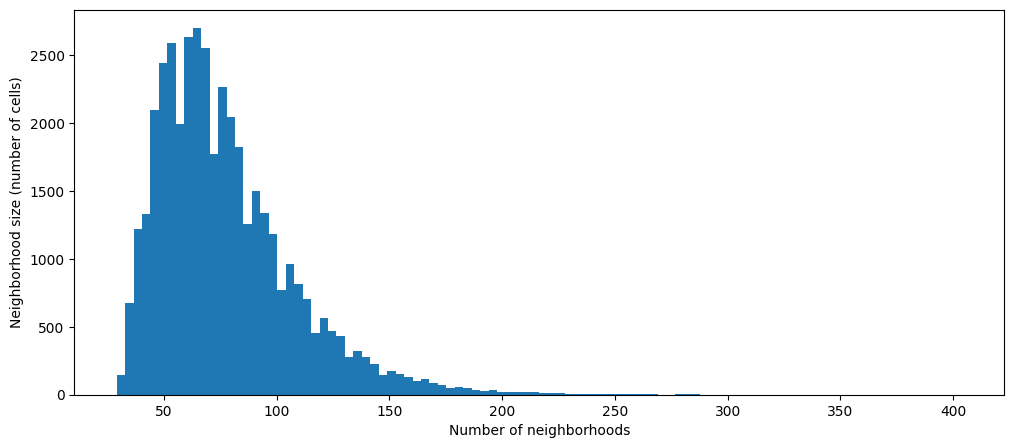

In [17]:
plt.rcParams["figure.figsize"] = [12,5]
nhood_size = np.array(mdata["rna"].obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100)

plt.xlabel('Number of neighborhoods')
plt.ylabel('Neighborhood size (number of cells)')
plt.savefig(f'{path_results}nhood_sizes.png')
plt.show()

### Count cells in neighborhoods

In [18]:
mdata = milo.count_nhoods(mdata, sample_col="sample")
    # we specify "sample" as the column containing the sample information)

This function populates mdatap["milo"] with an anndata object storing information on the number of cells from each sample counted in a neighbourhood - this count matrix will be used for DA testing.

In [19]:
mdata["milo"]

AnnData object with n_obs × n_vars = 166 × 41270
    var: 'index_cell', 'kth_distance'
    uns: 'sample_col'

### Differential abundance testing

First, convert "sex" to a continuous variable:

In [20]:
# mdata["rna"].obs["sex_continuous"] = mdata["rna"].obs["sex"].cat.codes
# mdata["rna"].obs["sex_continuous"] = mdata["rna"].obs["sex_continuous"].map({0: 1, 1: 0})
# milo.da_nhoods(mdata, design="~sex_continuous", solver = "edger")

The differential abundance test results are stored in mdata["milo"].var. In particular:
- logFC: stores the log-Fold Change in abundance (i.e. the slope of the linear model)
- PValue stores the p-value for the test
- SpatialFDR stores the p-values adjusted for multiple testing (accounting for overlap between neighbourhoods)

In [21]:
# mdata["milo"].var

In [22]:
mdata["rna"].obs["sex"] = mdata["rna"].obs["sex"].cat.reorder_categories(["male", "female"])
milo.da_nhoods(mdata, design="~sex")

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.


In [23]:
mdata["milo"].var

index_cell  kth_distance     logFC    logCPM  \
0                   P1_4_TTGCGTCAGCTTCGCG      1.162326 -1.531000  7.141925   
1                 AGTTGGTTCGGCCGAT_F01641      1.386964  1.007358  7.103082   
2      D337_Brus_Dis1ATAAGAGCAGACAAAT-1-6      1.429937  1.959181  7.079904   
3                 GTTCGGGAGAAACCAT_F01874      2.047760  0.247805  7.200758   
4                   CTGATCCTCGTGGGAA-SC45      1.844626 -2.923294  7.031702   
...                                   ...           ...       ...       ...   
41265               GCATCTCTCGAGAATA_T101      1.878688 -4.941214  7.742879   
41266              TGACTAGGTCTAGCGC-SC155      1.757376  1.837038  7.313513   
41267               GCCAAATGTCTCACCT_SC24      1.672357  1.371245  7.071448   
41268             CATTATCTCCATGAAC_F01639      2.242796 -2.187937  6.918688   
41269                AATCGGTGTCGGCACT-1-4      1.484668  0.024348  6.879665   

              F    PValue       FDR adjust.method comparison test  SpatialFDR  
0      0.958751  0.327597  0.463345            BH  sexfemale  glm    0.459581  
1      0.465964  0.494913  0.616048            BH  sexfemale  glm    0.612684  
2      1.862656  0.172449  0.302682            BH  sexfemale  glm    0.299464  
3      0.025975  0.871973  0.910539            BH  sexfemale  glm    0.909531  
4      4.451750  0.034972  0.109385            BH  sexfemale  glm    0.107903  
...         ...       ...       ...           ...        ...  ...         ...  
41265  9.661899  0.001896  0.030045            BH  sexfemale  glm    0.029099  
41266  1.482277  0.223523  0.358367            BH  sexfemale  glm    0.354926  
41267  0.900034  0.342868  0.477336            BH  sexfemale  glm    0.473629  
41268  2.612708  0.106151  0.222120            BH  sexfemale  glm    0.219478  
41269  0.001016  0.974580  0.982987            BH  sexfemale  glm    0.982730  

[41270 rows x 11 columns]

Diagnostic plots for DA analysis:

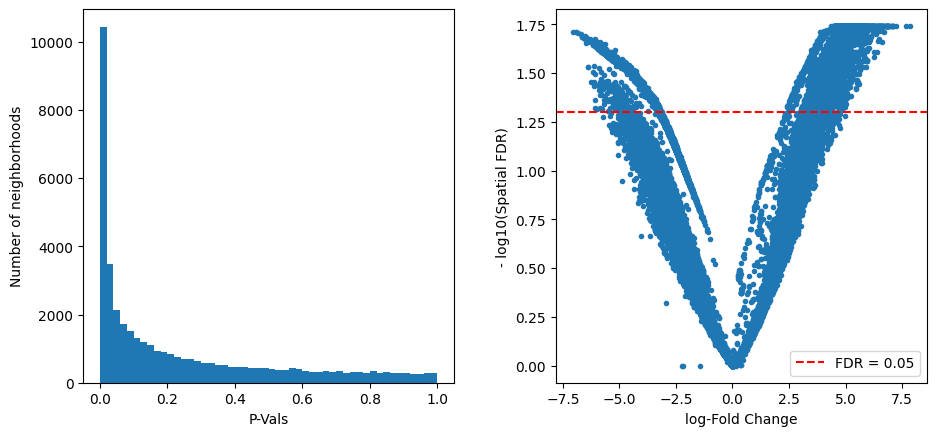

In [24]:
plt.rcParams["figure.figsize"] = [10,5]

plt.subplot(1,2,1)
plt.hist(mdata["milo"].var.PValue, bins=50);
plt.xlabel("P-Vals");
plt.ylabel("Number of neighborhoods")

plt.subplot(1,2,2)
plt.plot(mdata["milo"].var.logFC, -np.log10(mdata["milo"].var.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='FDR = 0.05')

plt.tight_layout(pad = 3)
plt.legend()
plt.savefig(f"{path_results}diagnostic_plots.png", bbox_inches='tight')

### Visualize DA results

To visualize DA results relating them to the embedding of single cells, we can build an abstracted graph of neighbourhoods that we can superimpose on the single-cell embedding. Here each node represents a neighbourhood, while edges indicate how many cells two neighbourhoods have in common. Here the layout of nodes is determined by the position of the index cell in the UMAP embedding of all single-cells. The neighbourhoods displaying singificant DA are colored by their log-Fold Change.

We try different values for the FDR threshold:

**FDR threshold = 5e-10:**

<Axes: title={'center': 'DA log-Fold Change'}, xlabel='X_milo_graph1', ylabel='X_milo_graph2'>

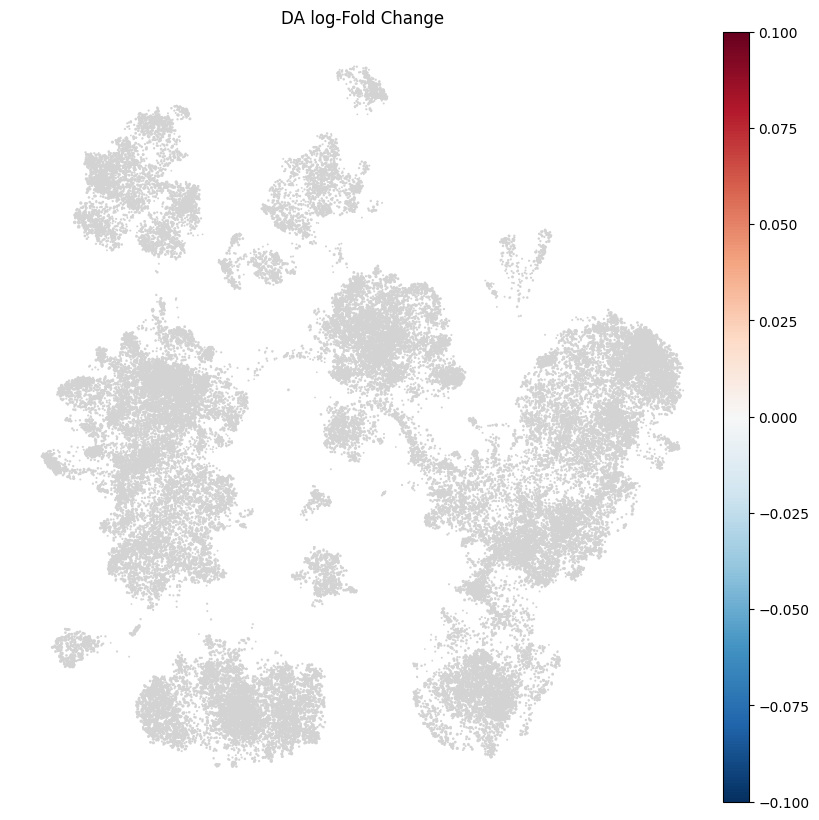

In [25]:
milo.build_nhood_graph(mdata)
plt.rcParams["figure.figsize"] = [10,10]

milo.plot_nhood_graph(mdata,
                      alpha=5e-10,
                      min_size=0.2,
                      return_fig = True
                     )

**FDR threshold = 5e-5:**

<Axes: title={'center': 'DA log-Fold Change'}, xlabel='X_milo_graph1', ylabel='X_milo_graph2'>

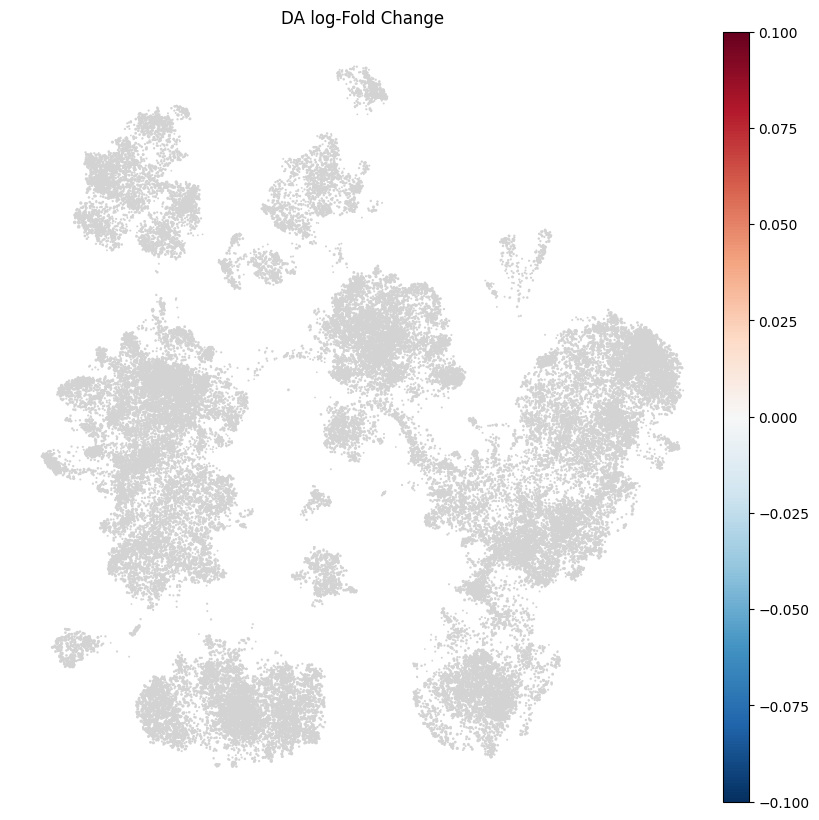

In [26]:
milo.plot_nhood_graph(mdata,
                      alpha=5e-5, 
                      min_size=0.2,
                      return_fig = True
                     )

**FDR threshold = 5e-2:**

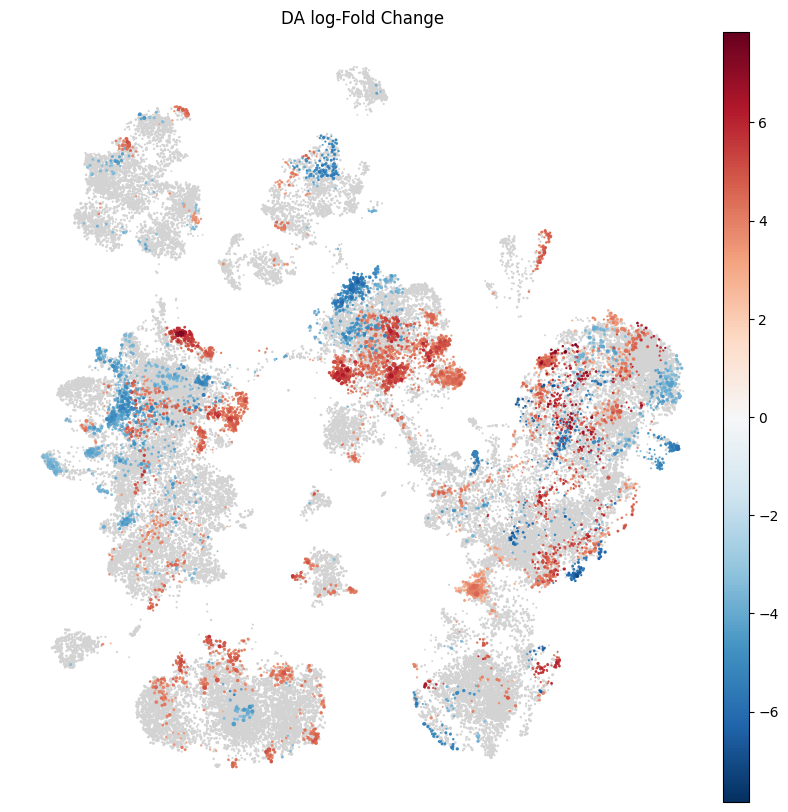

In [27]:
milo.plot_nhood_graph(mdata,
                      alpha=5e-2, 
                      min_size=0.2,
                      return_fig = True
                     )
plt.savefig(f"{path_results}DA_plot_5e-2.png", bbox_inches='tight')

**FDR threshold = 0.1:**

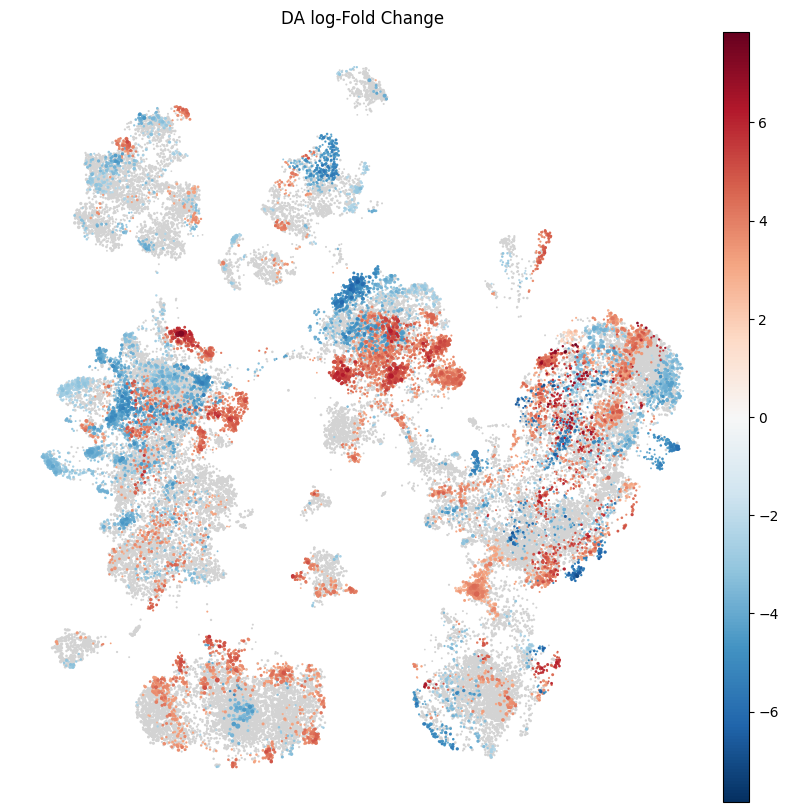

In [28]:
milo.plot_nhood_graph(mdata,
                      alpha=0.1, 
                      min_size=0.2,
                      return_fig = True
                     )
plt.savefig(f"{path_results}DA_plot_01.png", bbox_inches='tight')

### Visualize result by cell type

We assign a cell type label to each neighbourhood by finding the most abundant cell type within cells in each neighbourhood (after all, neighbourhoods are in most cases small subpopulations within the same cell type). We can label neighbourhoods in the results data.frame using the function milopy.core.annotate_nhoods. This also saves the fraction of cells harbouring the label.

Plot points will be sized based on the size of the neighborhood:

In [29]:
size_0 = 10
size_dict = {int(size): size_0 + i*25 for i, size in enumerate(np.arange(50, max(nhood_size) + 50, 50))}
size_dict

{50: 10,
 100: 35,
 150: 60,
 200: 85,
 250: 110,
 300: 135,
 350: 160,
 400: 185,
 450: 210}

In [30]:
def convert_sizes(lst, size_dict):
    bins = sorted(list(size_dict.keys()))
    indices = np.digitize(lst, bins)
    return [size_dict[bins[idx]] for idx in indices]

Function to plot DA per cell type (because we want to do this at all annotation levels):

In [31]:
def create_size_legend(ax, size_dict, y_offset = -0.092, border = True):

    x_positions = np.linspace(0.05, 0.95, len(size_dict)) 
    for x_pos, (size_label, scatter_size) in zip(x_positions, size_dict.items()):
        ax.scatter(x_pos, y_offset, s=scatter_size, 
                   edgecolor='black', facecolor = 'lightgrey',
                   transform = ax.transAxes, clip_on = False) 
        ax.text(x_pos, y_offset - 0.01, f'<{size_label}', transform = ax.transAxes,
                ha='center', va = 'top', fontsize = 10)
        
    if border:
        xmin, xmax = min(x_positions), max(x_positions)
        ymin, ymax = y_offset - 0.02, y_offset + 0.01
        
        rect = FancyBboxPatch(
            (xmin - 0.04, ymin),   # bottom-left
            (xmax - xmin) + 0.09,   # width
            (ymax - ymin),         # height
            boxstyle="round, pad=0, rounding_size=0.0045",
            transform=ax.transAxes,
            fill=False, edgecolor="lightgrey", 
            linewidth=1.1, clip_on=False
        )
        ax.add_patch(rect)

In [32]:
def DA_per_cell_type(df, ann_level, ax = None, vertical = False, signif = 5e-2, size_dict = size_dict, show_size = False, rtn = False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 40) if vertical else (50,8)) 
        ax.set_title(f'Annotation level {ann_level}', fontsize = 27)
    
    # remove unwanted categories
    df = df[~df['nhood_annotation'].isin(['Mixed', 'Unknown', 'None'])]
    df['nhood_annotation'] = df['nhood_annotation'].cat.remove_unused_categories()
    # sort based on median log fold-change
    median_logFC = df.groupby('nhood_annotation')['logFC'].median()
    sorted_groups = median_logFC.sort_values().index.tolist()
    df['nhood_annotation'] = pd.Categorical(df['nhood_annotation'], categories=sorted_groups, ordered=True)
    df = df.sort_values('nhood_annotation')
    
    # plot violin plot as grey:
    if vertical:
        sns.violinplot(y="nhood_annotation", x="logFC", data=df, inner=None, density_norm = "width", 
                       color="lightgrey", linecolor='black', orient='h', ax = ax)
    else:
        sns.violinplot(x="nhood_annotation", y="logFC", data=df, inner=None, density_norm = "width", 
                       color="lightgrey", linecolor='black', ax = ax)
    
    # overlay scatter points, with coloring based on SpatialFDR:
    for i, group in enumerate(df.groupby("nhood_annotation")):
        sub_df = group[1]
        
        # color
        colors = []
        sizes = convert_sizes(list(sub_df['Nhood_size']), size_dict)
        for fdr, logfc in zip(sub_df['SpatialFDR'], sub_df['logFC']):
            if fdr < signif and logfc > 0:
                colors.append('salmon')
            elif fdr < signif and logfc < 0:
                colors.append('steelblue')
            else:
                colors.append('lightgrey')

        # scatter
        if vertical:
            y = [i] * len(sub_df)  # this is to position it over the corresponding violin
            ax.scatter(sub_df['logFC'], y, color=colors, s = sizes, 
                       edgecolor='k', linewidth=0.5, alpha = 0.9)
        else:
            x = [i] * len(sub_df)
            ax.scatter(x, sub_df['logFC'], color=colors, s = sizes, 
                        edgecolor='k', linewidth=0.5, alpha = 0.9)
            
    # other plot details
    if vertical:
        ax.axvline(x=0, color='black', linestyle='--')
        if ann_level == 'finest':
            # manually set for the plot to fit properly
            ax.set_ylim(-1, len(sorted_groups))
        ax.tick_params(axis = 'both', labelsize=15)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_xlabel('log Fold Change (Female / Male)', fontsize=16)
        ax.set_ylabel('Neighborhood Annotation', fontsize=16)
    else:
        ax.axhline(y=0, color='black', linestyle='--')
        if ann_level == 'finest':
            # manually set for the plot to fit properly
            ax.set_xlim(-1, len(sorted_groups))
        ax.tick_params(axis = 'x', labelsize=22, labelrotation=90)
        ax.tick_params(axis = 'y', labelsize=18)
        ax.grid(axis='x', linestyle='--', alpha=0.7)
        ax.set_ylabel('log Fold Change (Female / Male)', fontsize=22)
        ax.set_xlabel('Neighborhood Annotation', fontsize=22)

    
    # legend
    legend_handles = [Patch(facecolor='lightgrey', edgecolor='black', label='Not significant'),
                      Patch(facecolor='salmon', edgecolor='black', label='Significantly enriched for female'),
                      Patch(facecolor='steelblue', edgecolor='black', label='Significantly enriched for male')]
    if vertical:
        ax.legend(handles=legend_handles, fontsize = 15, loc='upper center', bbox_to_anchor=(0.5, -0.03))
    else:
        ax.legend(handles=legend_handles, fontsize = 22, loc='lower right', bbox_to_anchor=(1, -1.1))

    if show_size == True:
        create_size_legend(ax, size_dict)
    
    if ax is None:
        plt.savefig(f"{path_results}celltypes_ann{ann_level}", bbox_inches='tight')
        plt.show()
    if rtn:
        return ax, sorted_groups

**Annotation level 2**

In [33]:
mdata["milo"]

AnnData object with n_obs × n_vars = 166 × 41270
    obs: 'sex', 'sample'
    var: 'index_cell', 'kth_distance', 'logFC', 'logCPM', 'F', 'PValue', 'FDR', 'adjust.method', 'comparison', 'test', 'SpatialFDR', 'Nhood_size'
    uns: 'sample_col', 'nhood'
    varm: 'X_milo_graph'
    varp: 'nhood_connectivities'

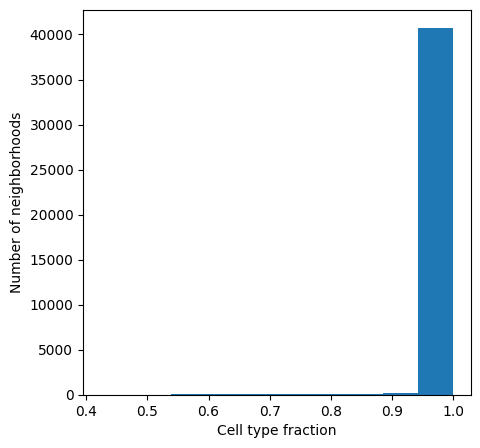

In [34]:
milo.annotate_nhoods(mdata, anno_col='ann_level_2')
# For the majority of neighborhoods, almost all cells have the same neighborhoods:
plt.rcParams["figure.figsize"] = [5,5]
plt.hist(mdata["milo"].var["nhood_annotation_frac"])
plt.xlabel("Cell type fraction")
plt.ylabel("Number of neighborhoods")

mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories("Mixed")
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

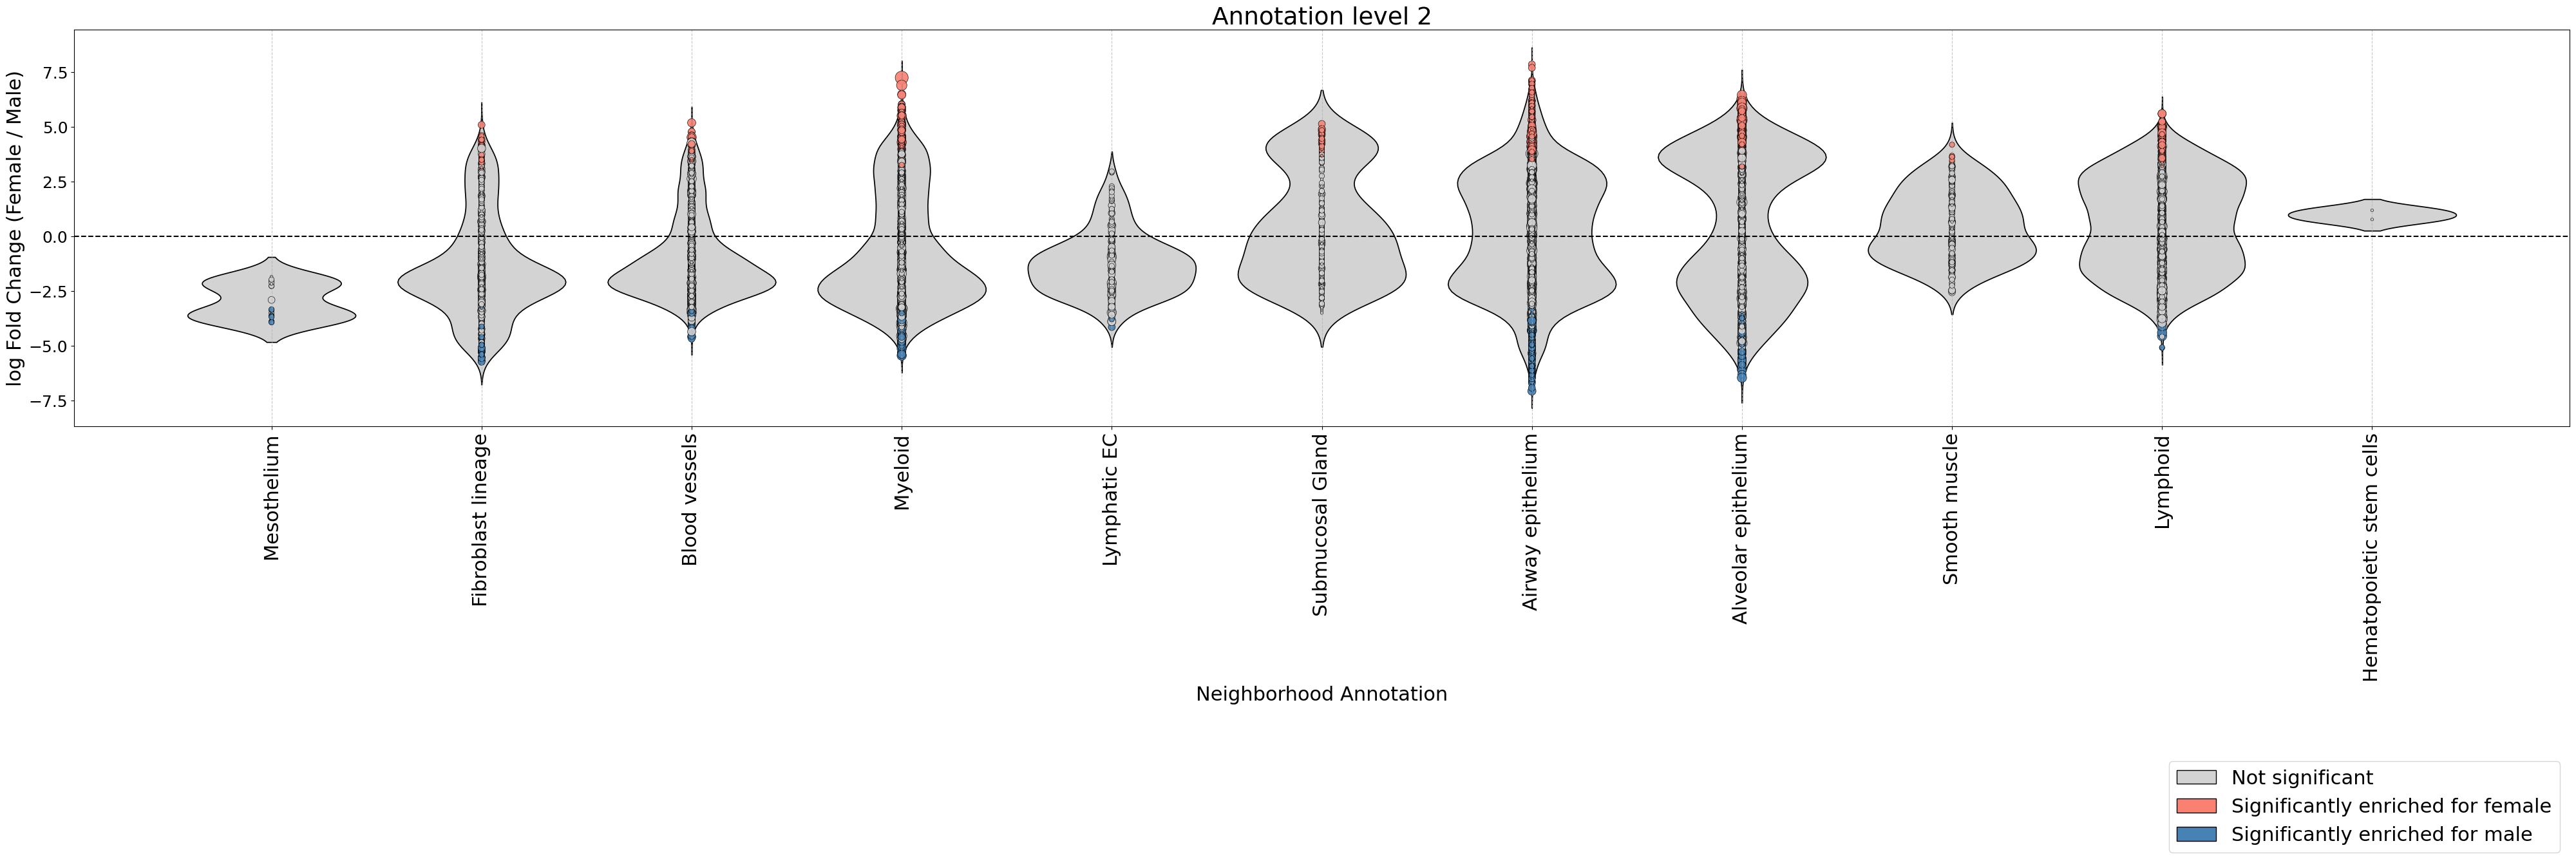

In [35]:
DA_per_cell_type(mdata["milo"].var, 2)

**Annotation level 3:**

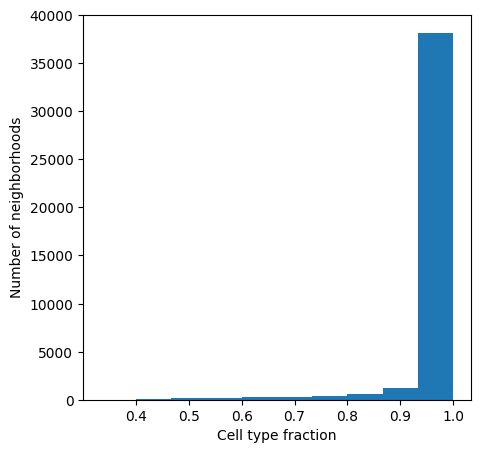

In [36]:
milo.annotate_nhoods(mdata, anno_col='ann_level_3')
# For the majority of neighborhoods, almost all cells have the same neighborhoods:
plt.rcParams["figure.figsize"] = [5,5]
plt.hist(mdata["milo"].var["nhood_annotation_frac"])
plt.xlabel("Cell type fraction")
plt.ylabel("Number of neighborhoods")

mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories("Mixed")
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

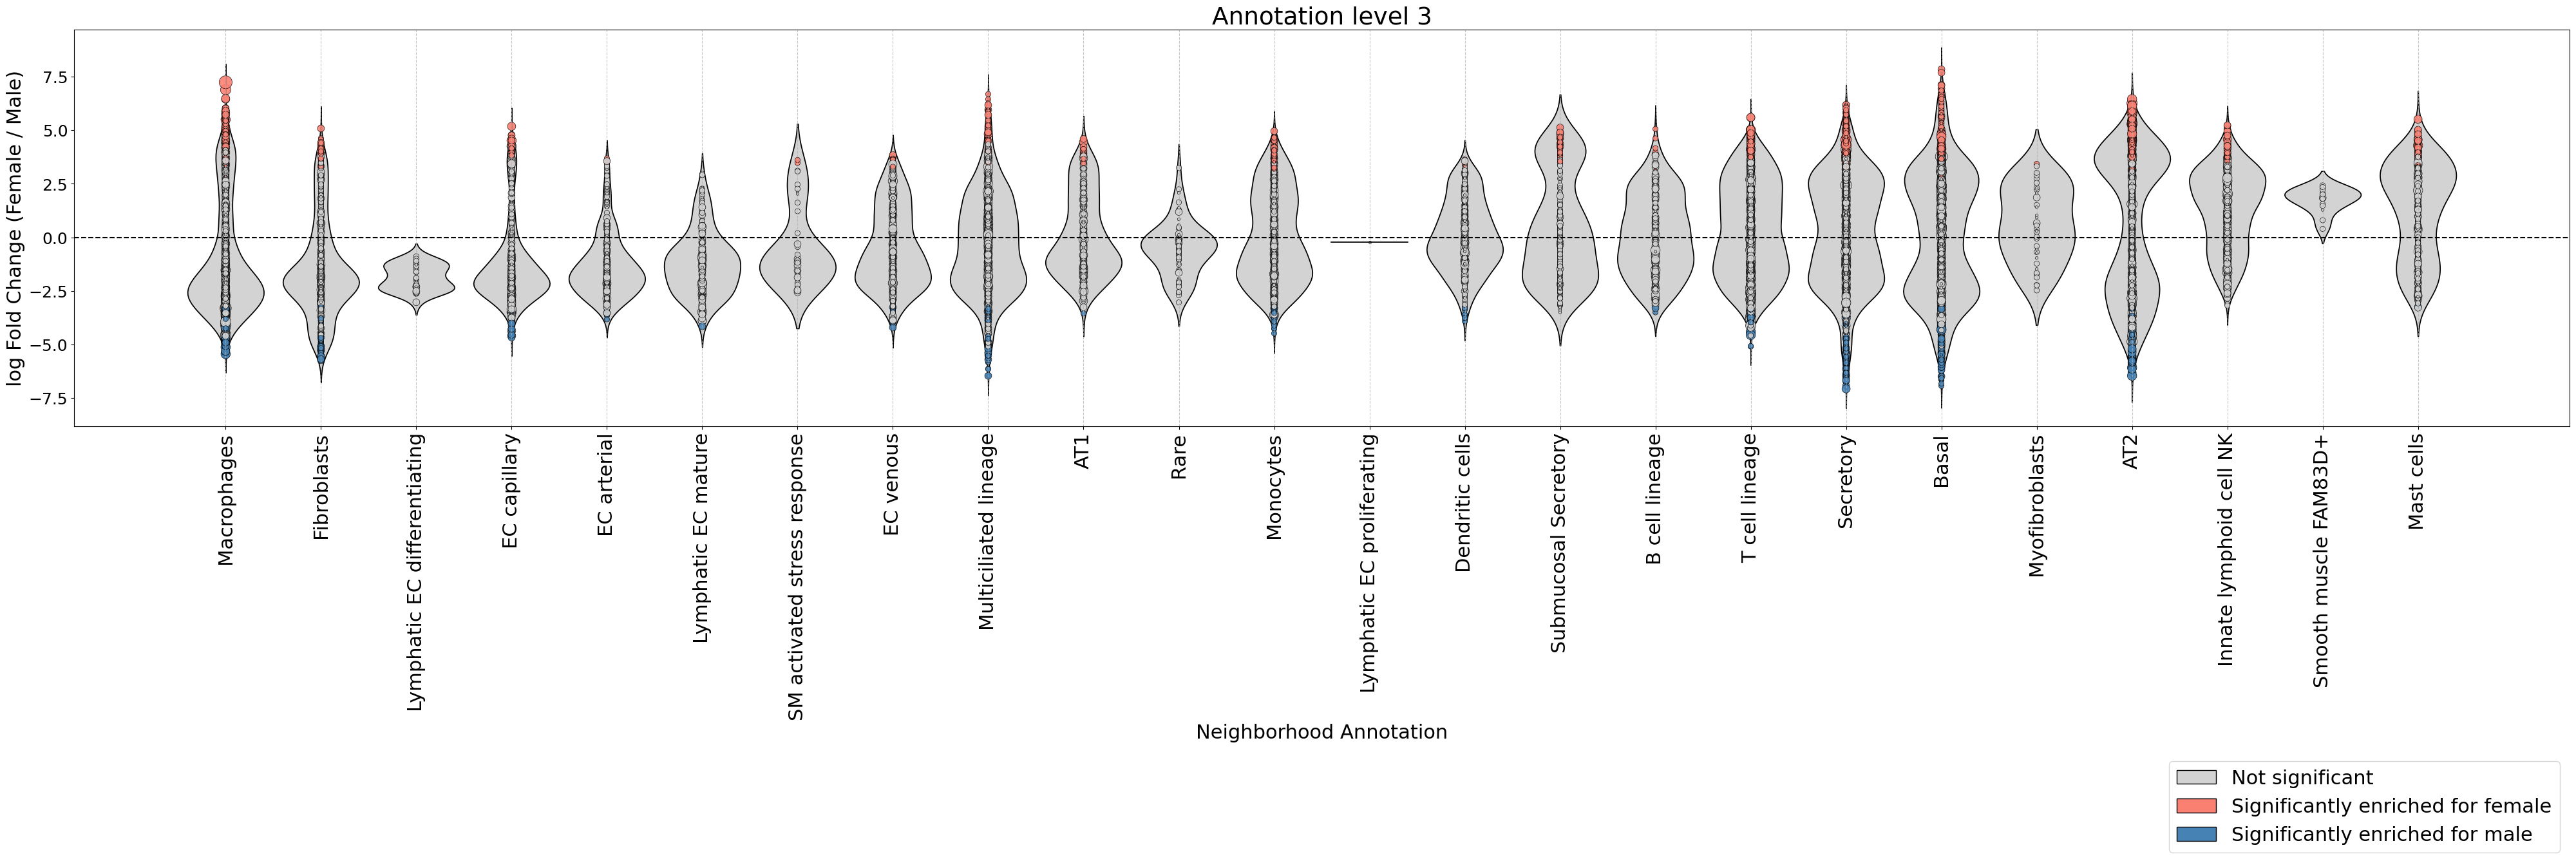

In [37]:
DA_per_cell_type(mdata["milo"].var, 3)

#### Annotation level 4

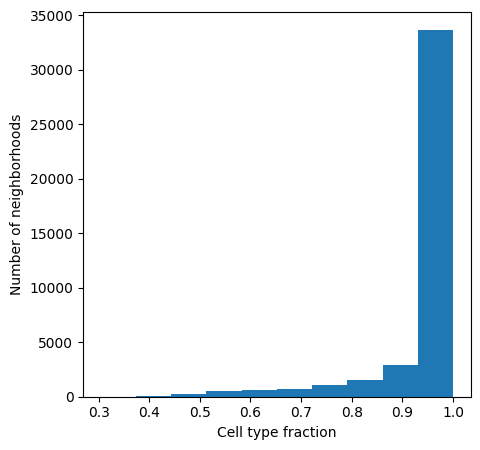

In [38]:
milo.annotate_nhoods(mdata, anno_col='ann_level_4')
# For the majority of neighborhoods, almost all cells have the same neighborhoods:
plt.rcParams["figure.figsize"] = [5,5]
plt.hist(mdata["milo"].var["nhood_annotation_frac"])
plt.xlabel("Cell type fraction")
plt.ylabel("Number of neighborhoods")

mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories("Mixed")
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

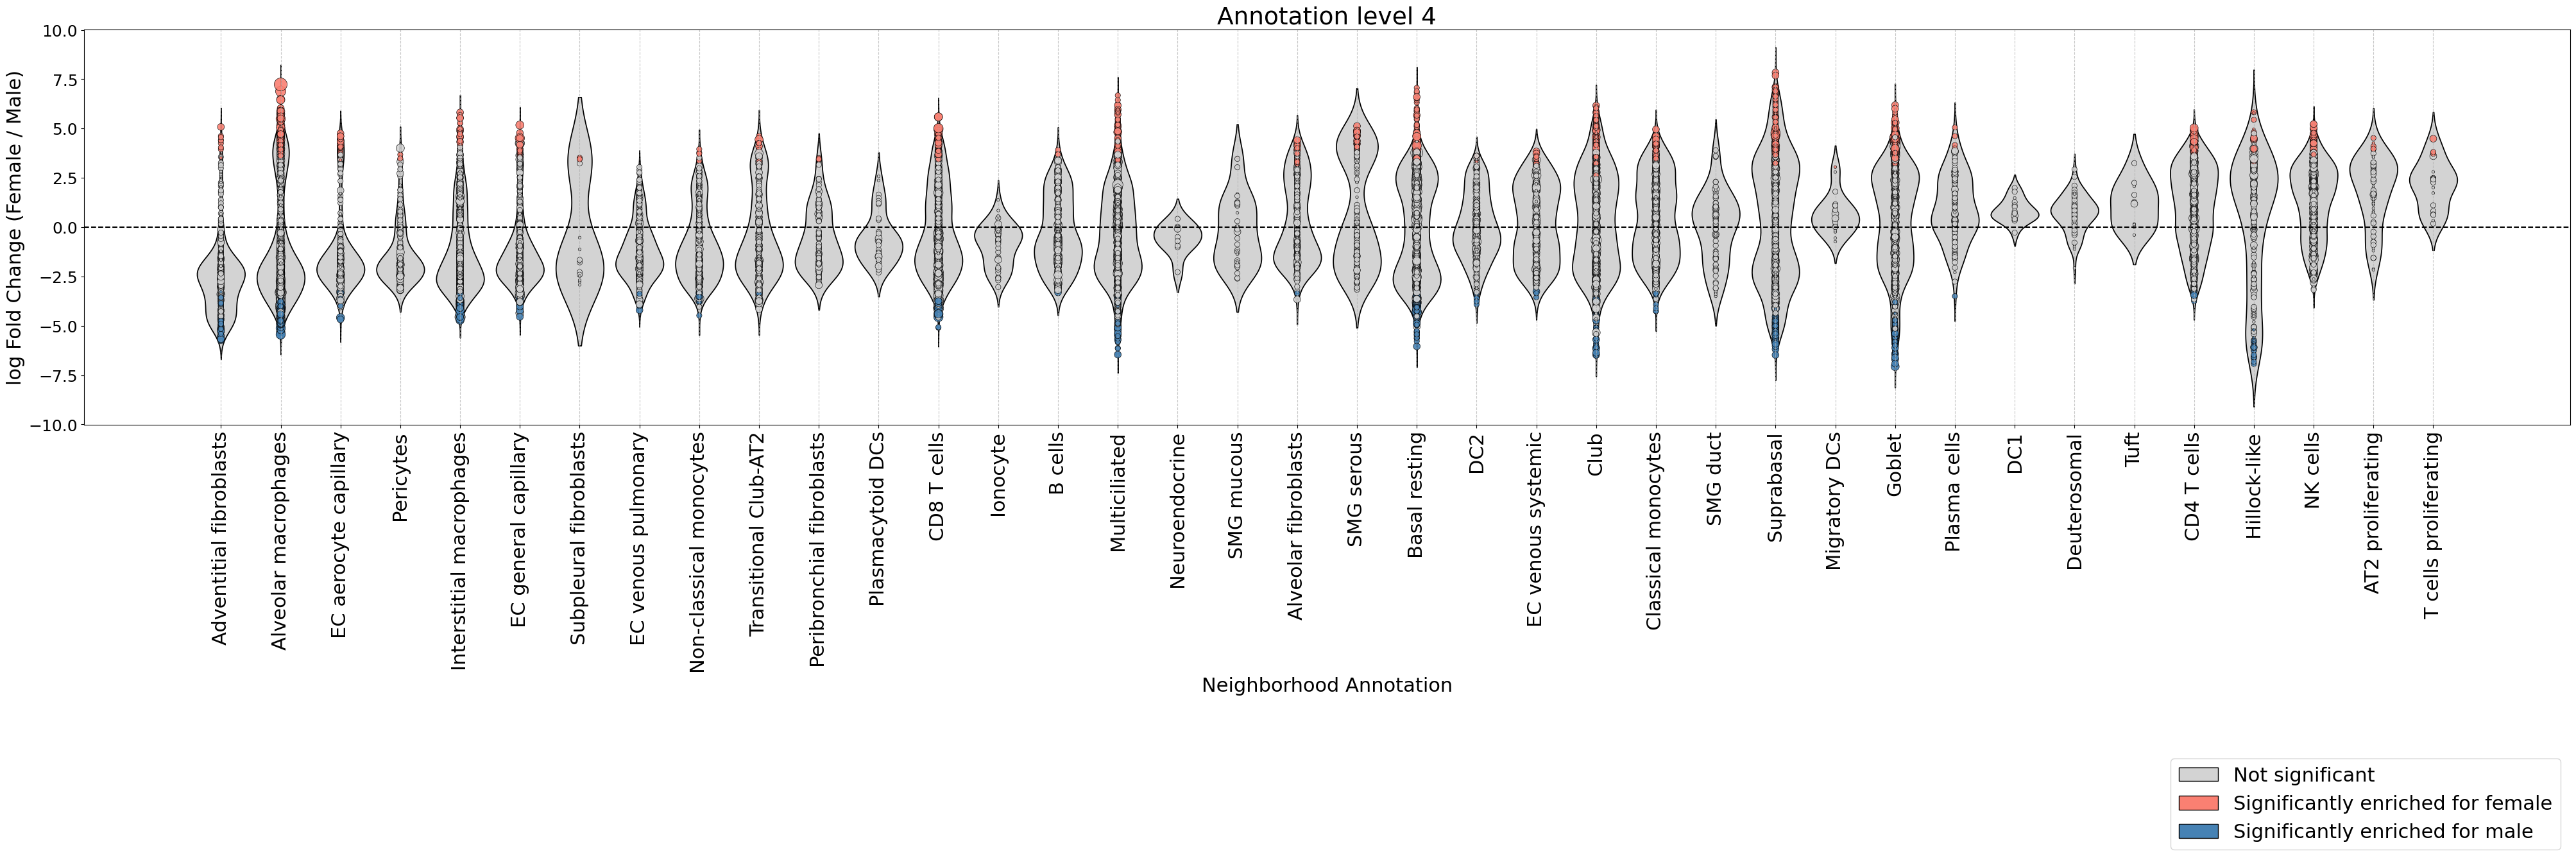

In [39]:
DA_per_cell_type(mdata["milo"].var, 4)

#### Annotation level 5

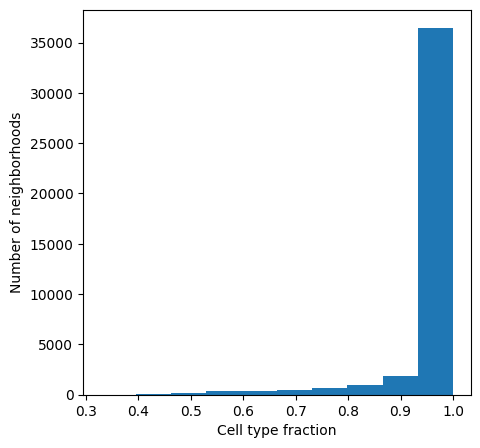

In [40]:
milo.annotate_nhoods(mdata, anno_col='ann_level_5')
# For the majority of neighborhoods, almost all cells have the same neighborhoods:
plt.rcParams["figure.figsize"] = [5,5]
plt.hist(mdata["milo"].var["nhood_annotation_frac"])
plt.xlabel("Cell type fraction")
plt.ylabel("Number of neighborhoods")

mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories("Mixed")
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

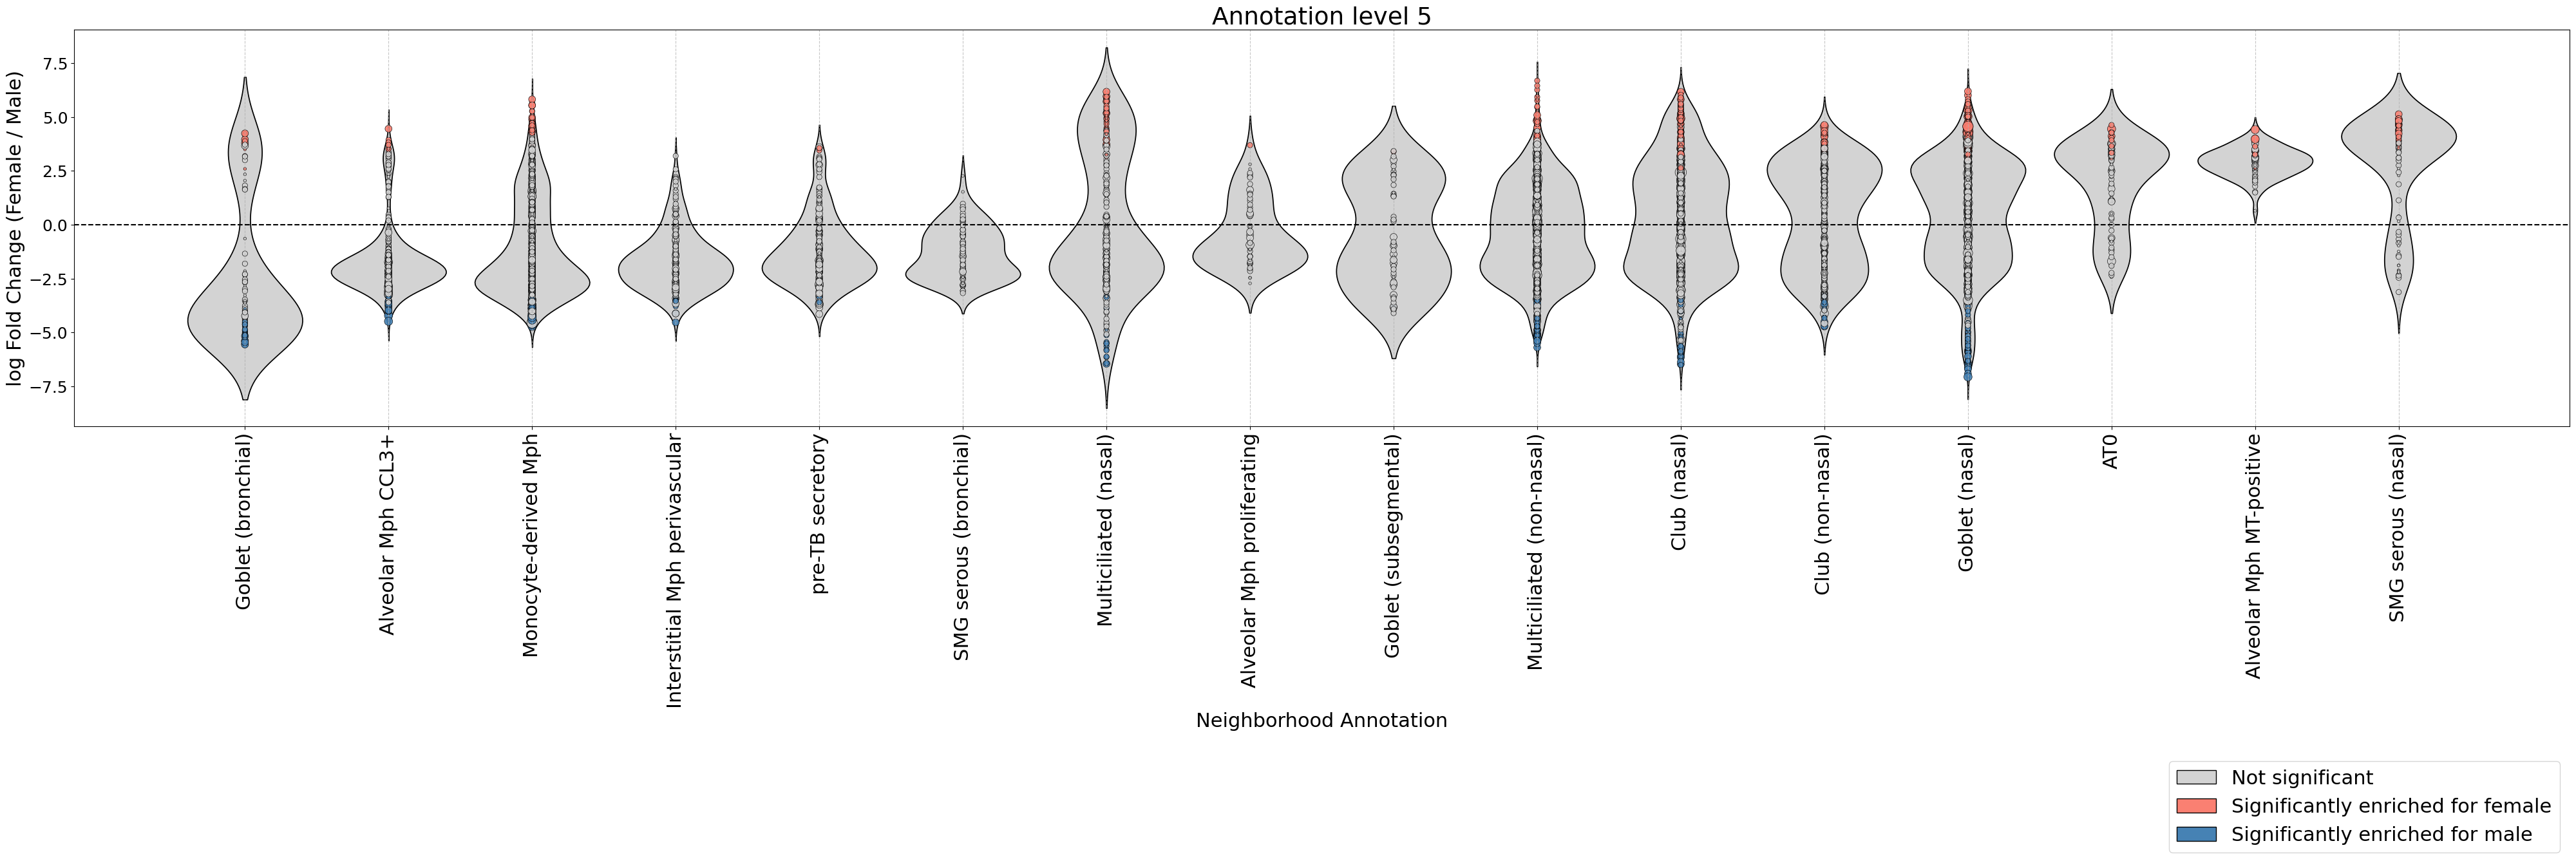

In [41]:
DA_per_cell_type(mdata["milo"].var, 5)

#### Annotation finest level

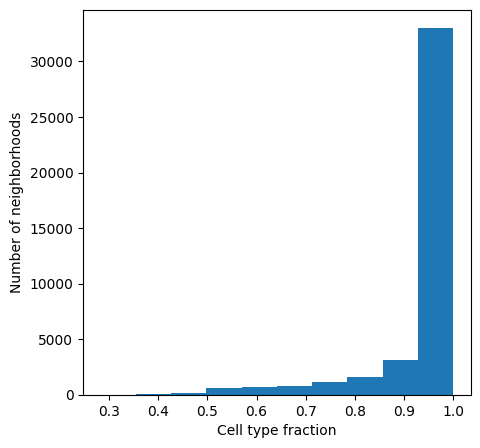

In [42]:
milo.annotate_nhoods(mdata, anno_col='ann_finest_level')
# For the majority of neighborhoods, almost all cells have the same neighborhoods:
plt.rcParams["figure.figsize"] = [5,5]
plt.hist(mdata["milo"].var["nhood_annotation_frac"])
plt.xlabel("Cell type fraction")
plt.ylabel("Number of neighborhoods")

mdata["milo"].var["nhood_annotation"] = mdata["milo"].var["nhood_annotation"].cat.add_categories("Mixed")
mdata["milo"].var.loc[mdata["milo"].var["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

plt.savefig(f"{path_results}nhood_annotation_fraction")
plt.show()

For a horizontal plot, run:

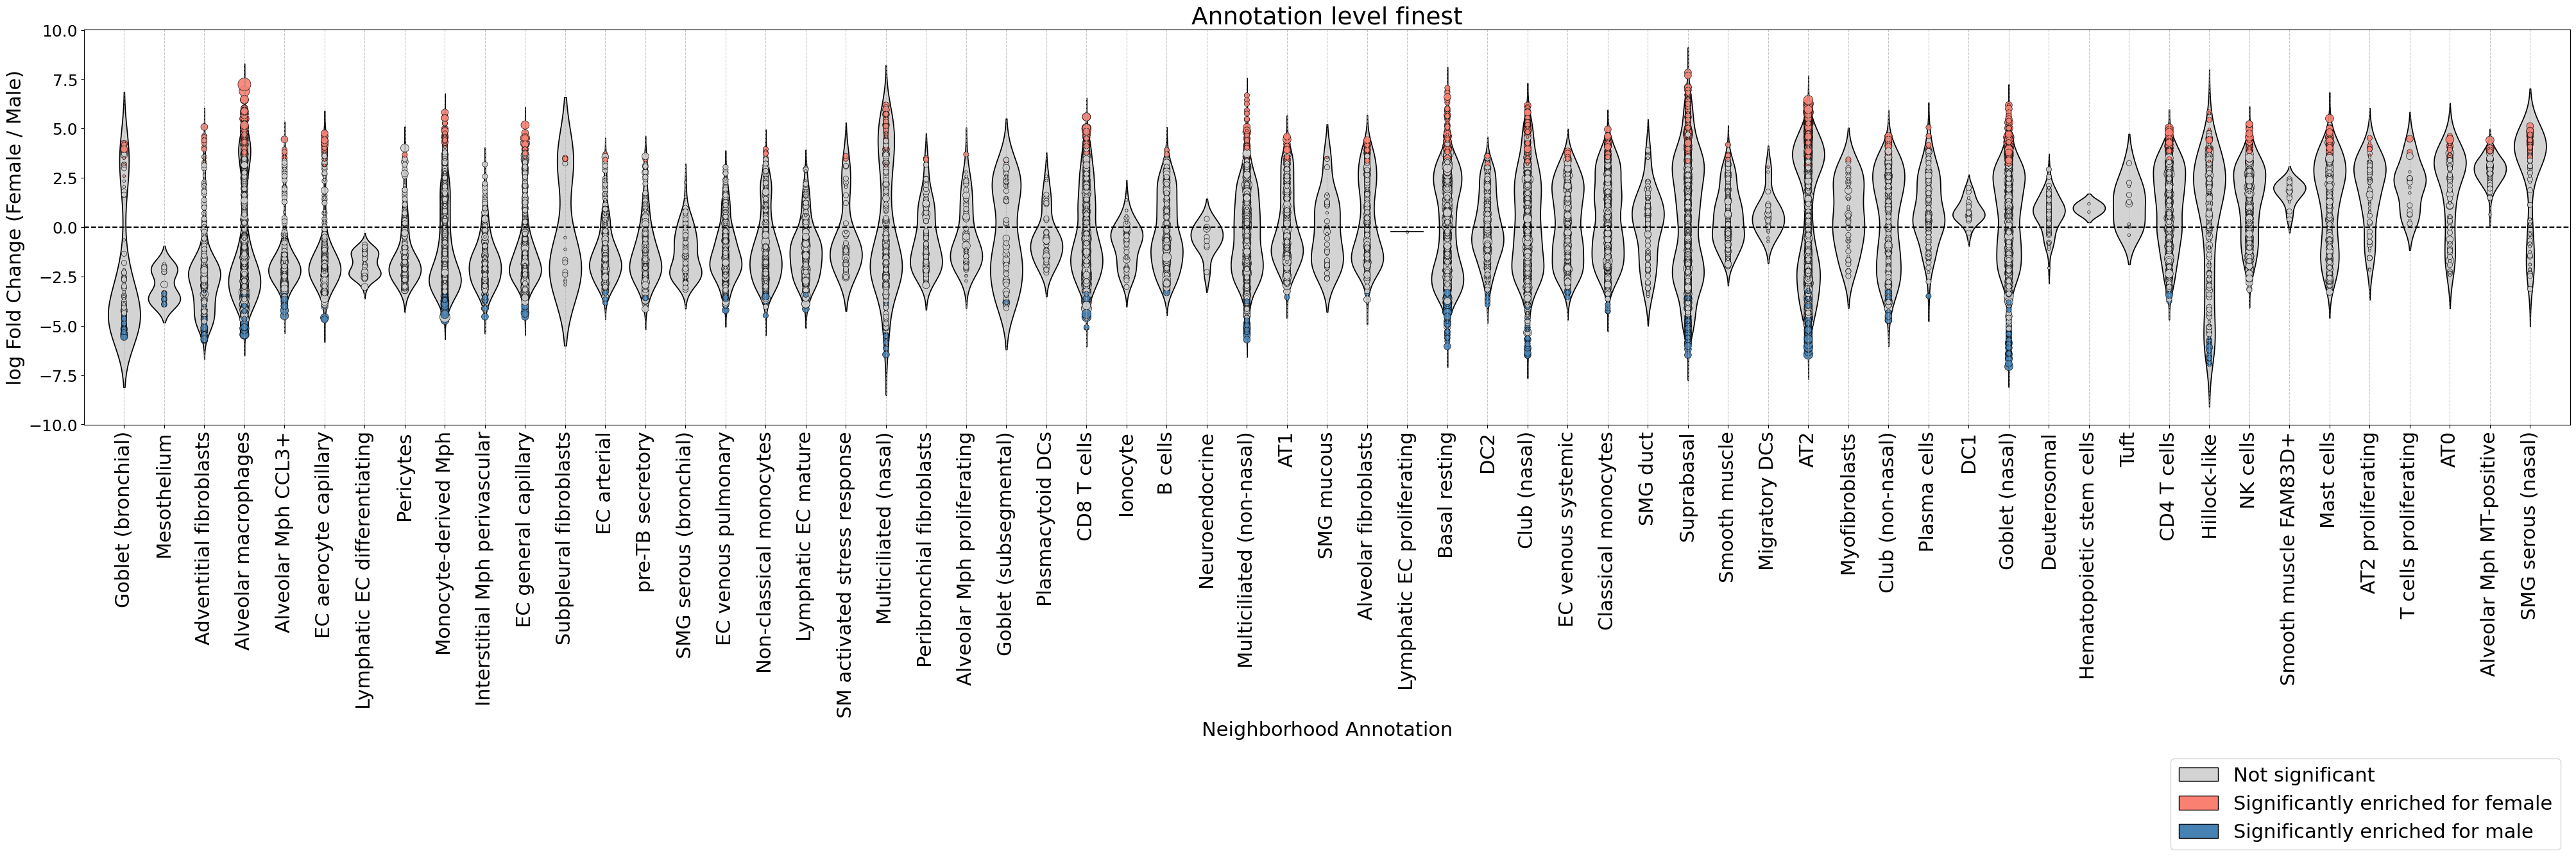

In [43]:
DA_per_cell_type(mdata["milo"].var, 'finest')

For a vertical plot, run:

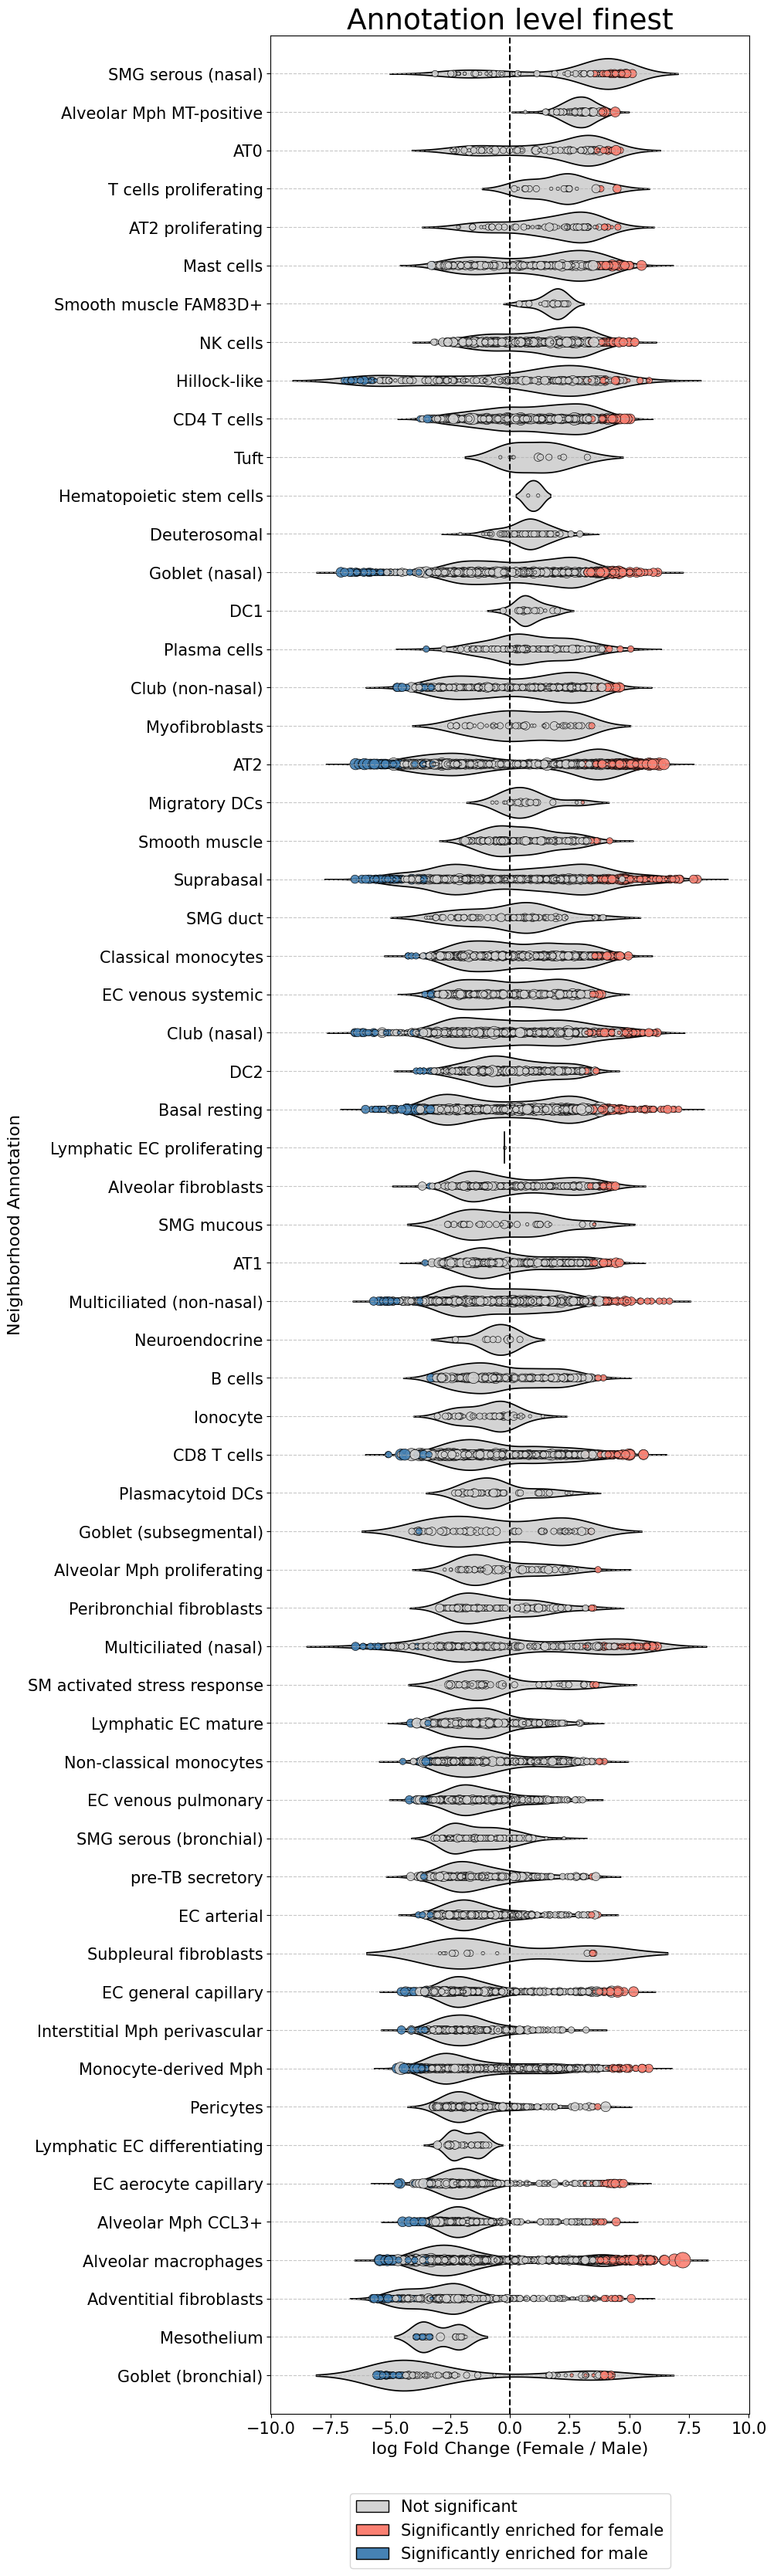

In [44]:
DA_per_cell_type(mdata["milo"].var, 'finest', vertical = True)

#### Store number of DA neighborhoods

In [45]:
with open('Exploration_results/cell_type_info.pickle', 'rb') as file:
    cell_type_info = pickle.load(file)

In [46]:
cell_types = [x for x in set(mdata["milo"].var['nhood_annotation']) if x not in ['Mixed', 'Unknown', 'None']]
for cell_type in cell_types:
    nhoods = mdata["milo"].var[mdata["milo"].var['nhood_annotation'] == cell_type]
    signif = nhoods[nhoods['SpatialFDR'] < 0.1]
    cell_type_info[cell_type]['num_DA_nhoods'] = len(signif)
    cell_type_info[cell_type]['prop_DA_nhoods'] = float(round(len(signif)/len(nhoods),2))

In [47]:
with open(f'{path_results}cell_type_info_with_DA.pickle', 'wb') as file:
    pickle.dump(cell_type_info, file)

#### Combine DA figure with more info

In [48]:
with open(f'{path_results}cell_type_info_with_DA.pickle', 'rb') as file:
    cell_type_info = pickle.load(file)

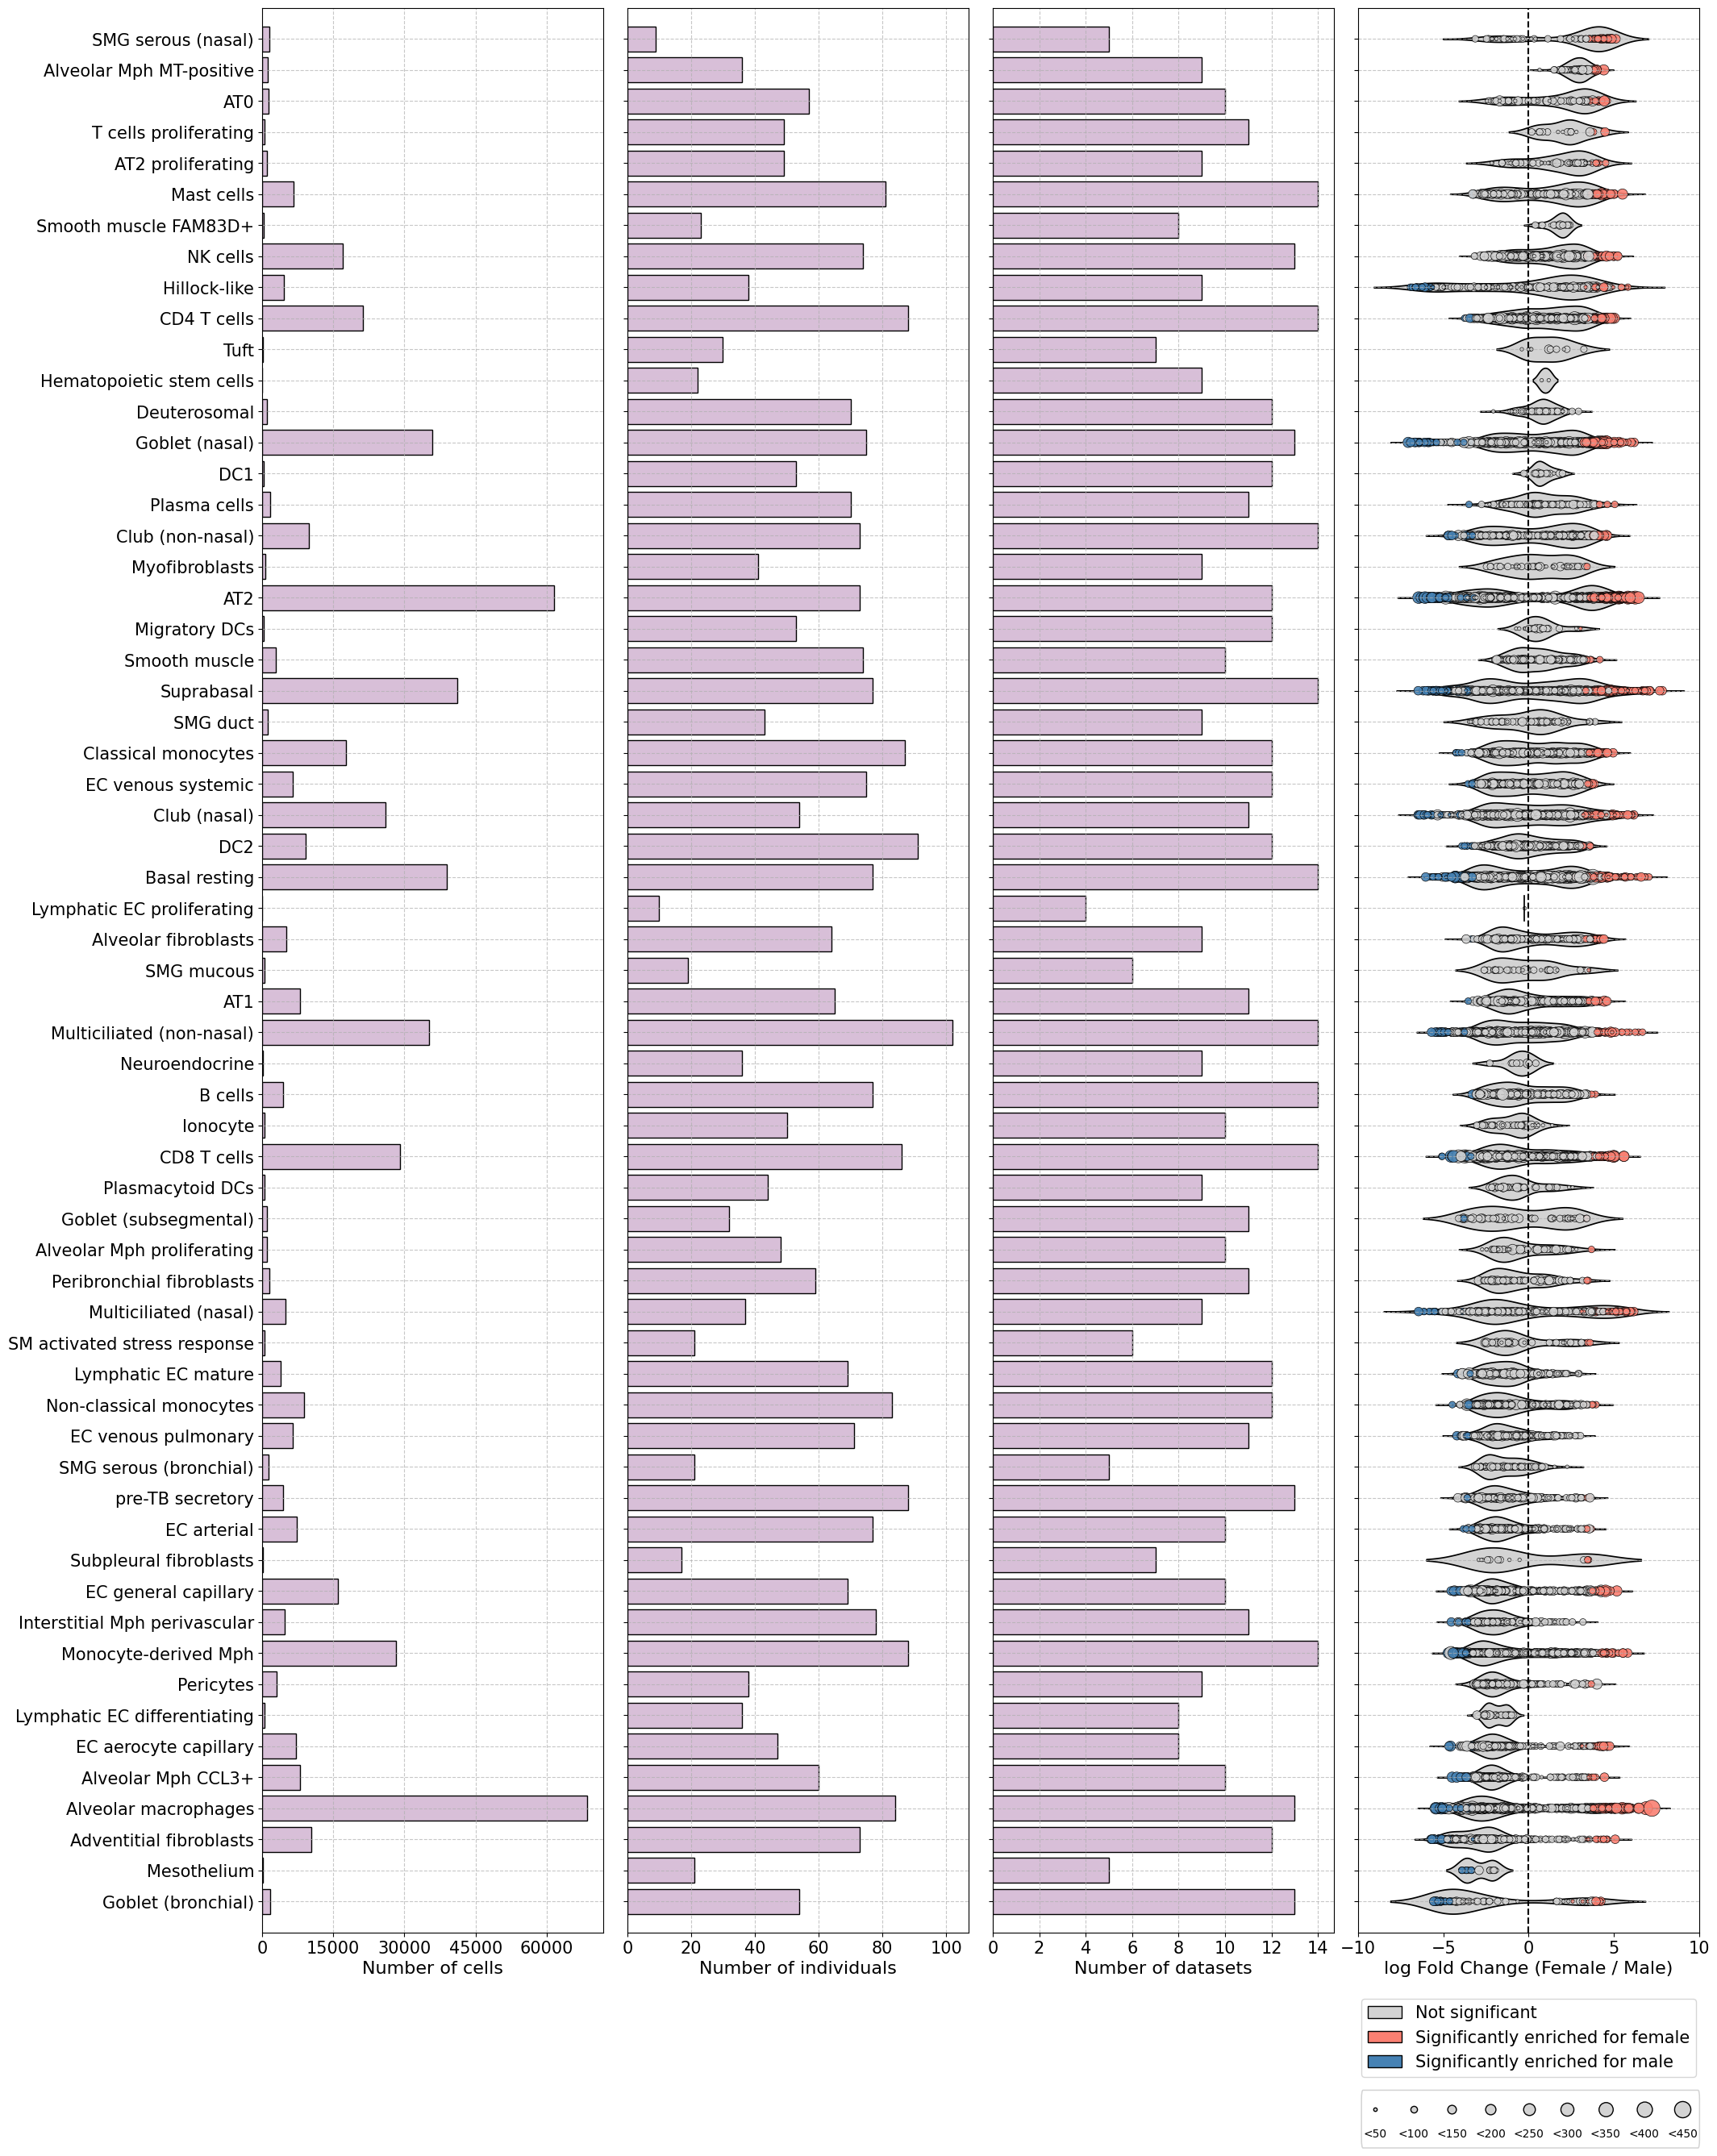

In [49]:
fig, axes = plt.subplots(
    1, 4, figsize=(23, 31), sharey=True, 
    gridspec_kw={"width_ratios": [1, 1, 1, 1], "wspace": 0.07}
)

# run DA function
ax_da, sorted_cell_types = DA_per_cell_type(mdata["milo"].var.copy(), 'finest', ax=axes[3], 
                                            vertical=True, rtn = True, show_size = True)

# collect data info
num_datasets = [cell_type_info[celltype]['num_datasets'] for celltype in sorted_cell_types]
num_donors = [cell_type_info[celltype]['num_donors'] for celltype in sorted_cell_types]
num_cells = [cell_type_info[celltype]['total_samples'] for celltype in sorted_cell_types]

axes[0].barh(sorted_cell_types, num_cells, color='thistle', edgecolor='black')
axes[0].set_xlabel('Number of cells', fontsize = 16)
axes[0].set_xticks(np.arange(0, 61000, 15000))

axes[1].barh(sorted_cell_types, num_donors, color='thistle', edgecolor='black')
axes[1].set_xlabel('Number of individuals', fontsize = 16)
axes[1].set_xticks(np.arange(0, 115, 20))

axes[2].barh(sorted_cell_types, num_datasets, color='thistle', edgecolor='black')
axes[2].set_xlabel('Number of datasets', fontsize = 16)
axes[2].set_xticks(np.arange(0, 15, 2))

for ax in axes[:3]:
    ax.tick_params(axis='both', labelsize=15)
    ax.grid(linestyle='--', alpha=0.7)
    ax.margins(y=0.01)

plt.tight_layout()
plt.savefig(f"{path_results}Combined_Celltypes_DA.png", bbox_inches='tight')
plt.show()

#### Linear regression

In [71]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

prop_DA_nhoods = [cell_type_info[celltype]['prop_DA_nhoods'] for celltype in sorted_cell_types]

data = pd.DataFrame({
    'prop_DA': prop_DA_nhoods,
    'num_cells': num_cells,
    'num_donors': num_donors,
    'num_datasets': num_datasets
})


X = data[['num_cells', 'num_donors']]
X = sm.add_constant(X)
y = data['prop_DA']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                prop_DA   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     6.379
Date:                Wed, 17 Sep 2025   Prob (F-statistic):            0.00313
Time:                        18:57:13   Log-Likelihood:                 23.096
No. Observations:                  61   AIC:                            -40.19
Df Residuals:                      58   BIC:                            -33.86
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3031      0.060      5.079      0.0

In [72]:
X = data[['num_cells', 'num_donors', 'num_datasets']]
X = sm.add_constant(X)
y = data['prop_DA']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                prop_DA   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     4.271
Date:                Wed, 17 Sep 2025   Prob (F-statistic):            0.00866
Time:                        18:57:29   Log-Likelihood:                 23.217
No. Observations:                  61   AIC:                            -38.43
Df Residuals:                      57   BIC:                            -29.99
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2607      0.108      2.421   

In [73]:
X = data[['num_cells', 'num_datasets']]
X = sm.add_constant(X)
y = data['prop_DA']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                prop_DA   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     4.854
Date:                Wed, 17 Sep 2025   Prob (F-statistic):             0.0112
Time:                        18:58:11   Log-Likelihood:                 21.752
No. Observations:                  61   AIC:                            -37.50
Df Residuals:                      58   BIC:                            -31.17
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3340      0.100      3.343   

#### Citation

This notebook is adapted from the guided example notebook for the Pertpy implementation of Milo:
Heumos, L., May, L., Peidli, S., Ostner, J., Sturm, G., Dann, E., Ji, Y., Zhang, X., Wu, X., Green, T., & Schumacher, A. (2025). Milo – KNN based differential abundance analysis. Retrieved from https://pertpy.readthedocs.io/en/stable/tutorials/notebooks/milo.html.

Violin plotting is inspired from the old Milopy implementation of Milo:
Dann, E. (2021). Differential abundance analysis in python with milopy. GitHub. https://github.com/emdann/milopy/blob/master/notebooks/milopy_example.ipynb